<a href="https://colab.research.google.com/github/Julianpucheta/HCSPD2022/blob/main/Clase_01_HCSPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**En éste** Notebook están las instrucciones para correr algunas simulaciones de procesos dinámicos.
Algunas están en .m y otras en Python.
Si se quiere emplear un script de Octave, primero debe instalarse.

In [ ]:
#Instalo el Octave para Linux
!apt install octave

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave is already the newest version (4.2.2-1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Se va a escribir al script en el entorno del Colabs, y para ello se escribe el archivo empleando %%writefile con el nombre del archivo.


In [ ]:
%%writefile Controlador.m
warning('off','all');
%Modelo extraído de https://www.redalyc.org/articulo.oa?id=70780106
clear;%close all;
ii=0;t_etapa=10*2.5e-03;wRef=2;tF=10;
color_='r';
Ts=t_etapa;
u=0;TL=0.01;
tita_Ref=2;
kt=6e-5 ; %Nm/A
Bm=0.005; %Nms/rad
kr=0.01 ;% Nm/rad
ke=0.055;% Vs/rad
Lm= 5e-3;%mHy
Rm=0.2;% ohm
J=0.0044 ;%Nms^2/ rad
Mat_A=[0 1 0 ;
    %     0 -kr/J-Bm/J kt/J;%estaba incorrecto el de w, decia -kr/J -Bm/J
    0 -Bm/J kt/J;%kr va a ser Torque de carga TL
    0 -ke/Lm -Rm/Lm];
disp('Autovalores de lazo abierto en:')
eig(Mat_A) %1/400 es suficiente para el tiempo de muestreo
Mat_B= [0;0;1/Lm];
Mat_C=[1 0 0];
A_d=Mat_A';
B_d=Mat_C';
C_d=Mat_B';
Aa=[Mat_A,[0;0;0];-Mat_C,0];
Ba=[Mat_B;0];
% Mat_A=Aa;Mat_B=Ba;
Mat_M=[Ba Aa*Ba Aa^2*Ba Aa^3*Ba];%Matriz Controlabilidad
auto_val=eig(Aa);
c_ai=poly(auto_val);
Mat_W=[c_ai(4) c_ai(3) c_ai(2) 1;
    c_ai(3) c_ai(2) 1 0;
    c_ai(2) 1 0 0;
    1 0 0 0];
Mat_T=Mat_M*Mat_W;%
A_controlable=inv(Mat_T)*Aa*Mat_T; %Verificacion de que T este bien
a4=-A_controlable(4,1);
a3=-A_controlable(4,2);
a2=-A_controlable(4,3);
a1=-A_controlable(4,4);
q4=1e2;
q3=1e5;
q2=1e5;
q1=1e5; 
Q=diag([q1 q2 q3 q4]);
R=1;
p1=.5*(-4*a4*R+sqrt((4*a4*R)^2+16*q1*R));
p2=.5*(-4*a3*R+sqrt((4*a3*R)^2+16*q2*R));
p3=.5*(-4*a2*R+sqrt((4*a2*R)^2+16*q3*R));
p4=.5*(-3*a1*R+sqrt((3*a1*R)^2+8*q4*R));
P=diag([p1 p2 p3 p4]);P(4,:)=[p1 p2 p3 p4];
Ka=(([p1 p2 p3 p4])/(2*R))*inv(Mat_T);
K=Ka;
p_des=[-1;-2;-50;-1.51];
alfa_ia=poly(p_des);
%K=fliplr(alfa_ia(2:5)-c_ai(2:5))*inv(Mat_T);
disp('Controlador ampliado en ')
eig(Aa-Ba*Ka)
%Cálculo del Observador---------------------------------------------------
q3=1e0; %% aumenta K3 peligroso 
q2=1e0;% % aumenta K2
q1=1e3; % aumenta K1
Qo=diag([q1 q2 q3 ]);
R=1e0;
Mat_Mo=[B_d A_d*B_d A_d^2*B_d ];%Matriz Controlabilidad
auto_val=eig(A_d);
c_ai=poly(auto_val);
Mat_Wo=[c_ai(3) c_ai(2) 1 ;
    c_ai(2) 1 0 ;
    1 0 0 ];
Mat_To=Mat_Mo*Mat_Wo;%
A_o=inv(Mat_To)*A_d*Mat_To; %Verificacion de que T este bien
a3=-A_o(3,1);
a2=-A_o(3,2);
a1=-A_o(3,3);
Q=diag([q1 q2 q3 ]);
R=1e-1;
p1=.5*(-4*a3*R+sqrt((4*a3*R)^2+16*q1*R));
p2=.5*(-4*a2*R+sqrt((4*a2*R)^2+16*q2*R));
p3=.5*(-3*a1*R+sqrt((3*a1*R)^2+8*q3*R));
P=diag([p1 p2 p3 ]);P(3,:)=[p1 p2 p3 ];
Ko=((([p1 p2 p3 ])/(2*R))*inv(Mat_To))';
disp('Observador en ')
eig(A_d-B_d*Ko')
% break
X=[0; 0;0];%ia=xant(1);wr=xant(2);titar=xant(3);
psi=0;ii=0;
x_hat=[0;0;0];
t=0:t_etapa:tF;x1=0*t;x2=x1;x3=x1;
for t=0:t_etapa:tF
    ii=ii+1;
    X=modmotorv(t_etapa, X, [u,TL]);
    psi=psi+t_etapa*(tita_Ref-X(3));
    Xc(1)=X(3);Xc(2)=X(2);Xc(3)=X(1);
    %     u=-K(1:3)*Xc'-K(end)*psi; 
    u=-K(1:3)*x_hat-K(end)*psi; 
    x1(ii)=X(1);%Corriente
    x2(ii)=X(2);%wp
    x3(ii)=X(3);%tita X=[ia;wr;titar];
    acc(ii)=u;
    y_sal=Mat_C*Xc';
    %________OBSERVADOR__________
    y_sal_O=Mat_C*x_hat;
    %     y_sal=Mat_C*estado;
    x_hatp=Mat_A*x_hat+Mat_B*u+Ko*(y_sal-y_sal_O);
    x_hat=x_hat+t_etapa*x_hatp;
end
t=0:t_etapa:tF;
hfig1 = figure(1); set(hfig1, 'Visible', 'off');
subplot(3,1,1);hold on;
plot(t,x1,color_);title('Corriente i_t, Amp');
subplot(3,1,2);hold on;
plot(t,x3,color_);title('Salida y, \theta_t');
subplot(3,1,3);hold on;
plot(t,acc,color_);title('Entrada u_t, v_a');
xlabel('Tiempo [Seg.]');
print(hfig1,'Tita_t','-dpng');
save('Datos_Controlador.mat','-v7');

Writing Controlador.m


In [ ]:
%%writefile modmotorv.m
function [X]=modmotorv(t_etapa, xant, accion)
h=1e-7;
Laa=366e-6;J=5e-9;Ra=55.6;B=0;Ki=6.49e-3;Km=6.53e-3;
Laa= 5e-3;
Bm=0.005;
J=0.0044;
Ra=0.2;
Km=0.055; %ke
Ki=6e-5; %kt 
h=2.5e-03; %https://www.redalyc.org/articulo.oa?id=70780106
% kt=6*10^-5 ; %Nm/A Originales, de MH
% Bm=0.005; %Nms/rad
% kr=0.01 ;% Nm/rad 
% ke=0.055;% Vs/rad
% Lm= 5*10^-3;%mHy
% Rm=0.2;% ohm
% J=0.0044 ;%Nms^2/ rad
x=xant;
ia=xant(1);wr=xant(2);titar=xant(3);Va=accion(1);TL=accion(2);
for ii=1:t_etapa/h
    ia_p=-(Ra/Laa)*ia-(Km/Laa)*wr+(1/Laa)*Va;
    wr_p=(Ki/J)*ia-(Bm/J)*wr-(1/J)*TL;
    ia=ia+ia_p*h;
    wr=wr+wr_p*h;
    titar=titar+wr*h;
end
X=[ia;wr;titar];

Overwriting modmotorv.m


Con la instrucción !octave se ejecuta el Octave, y seguidamente le indica el nombre del .m.
En el mismo código puede agregarse un par de comandos para cargar el resultado y mostrarlo.
Por ejemplo, mostrando una imágen de gráficas.

Autovalores de lazo abierto en:
ans =

    0.00000
   -1.14022
  -39.99614

Controlador ampliado en 
ans =

  -32.35394 +  0.00000i
   -0.48391 +  0.94891i
   -0.48391 -  0.94891i
   -8.61455 +  0.00000i

Observador en 
ans =

   -0.53839 +  1.48371i
   -0.53839 -  1.48371i
  -40.14050 +  0.00000i



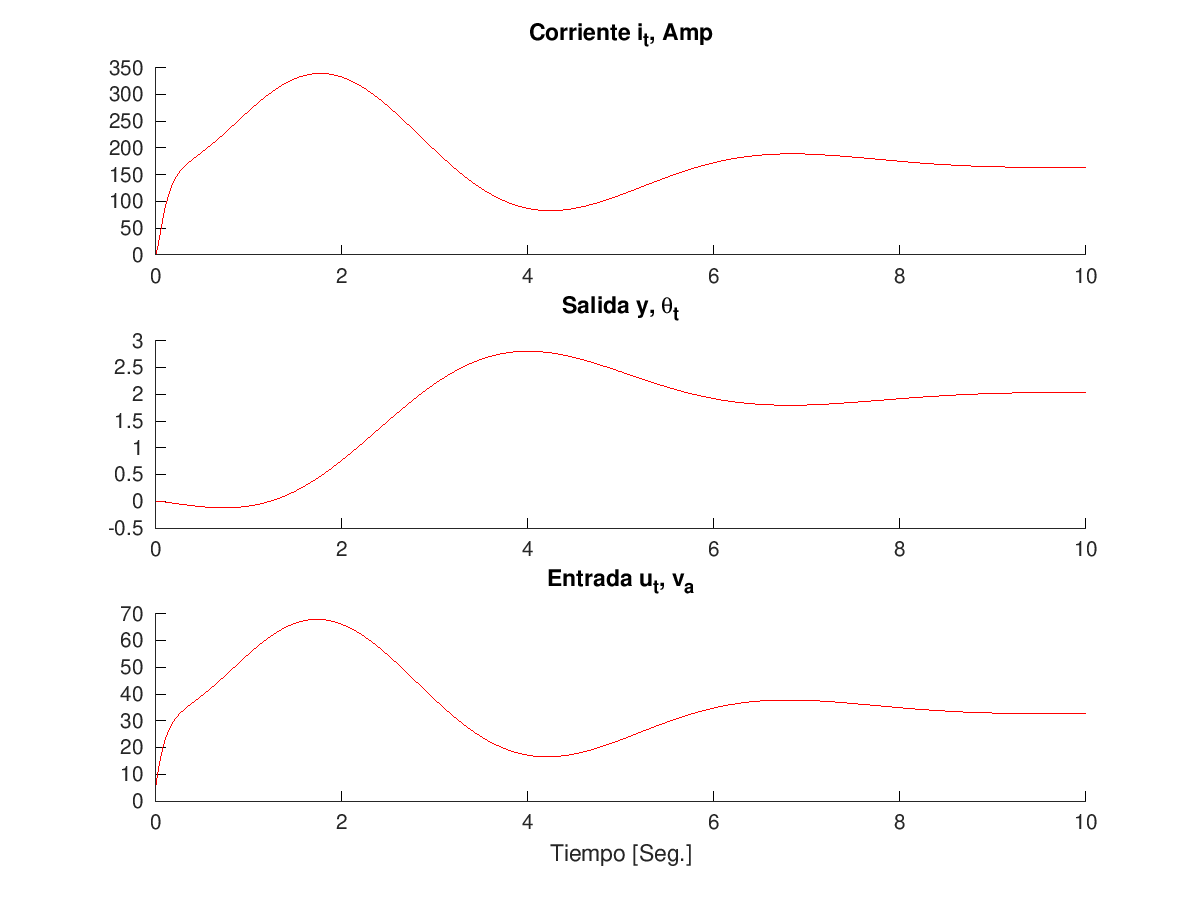

In [ ]:
# -W : no window system
!octave -W Controlador.m
import scipy.io
mat = scipy.io.loadmat('/content/Datos_Controlador.mat')
from PIL import Image
imt = Image.open("/content/Tita_t.png")
imt

**Si se quiere emplear Python**, se puede escribir el código directamente en el mismo cuaderno, y correrlo. A continuación se muestra el script para simular un circuito RLC.

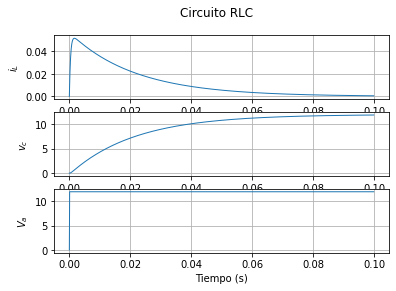

In [ ]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt
from pylab import *
h=1e-4;t_simul=1e-1;R=2.2e2;L=100e-3;C=100e-6;
#h=1e-9;t_simul=1e-3;R=2.2e3;L=10e-6;C=100e-9;
##
A=np.array([[-R/L, -1/L],[1/C,0]])
B=np.array([[1/L],[0]])
x1=np.linspace(0,0,int(t_simul/h))
x2=np.linspace(0,0,int(t_simul/h))
u=np.linspace(0,0,int(t_simul/h))
t=np.linspace(0,0,int(t_simul/h))
Va=np.array([0])
x=np.array([[0],[0]])
xp=np.array([[0],[0]])
####x2=x1 ojo , porque queda igualado para todo el programa
for ii in range(int(t_simul/h)):
  xp=np.matmul(A, x)+B*Va
  x=x+xp*h
  u[ii] = Va
  Va = 12
  x1[ii] = x[0]
  x2[ii] = x[1]
  t[ii] = ii*h
##end
fig, axs = plt.subplots(3)
fig.suptitle('Circuito RLC')
axs[0].plot(t, x1, linewidth =1.0)
axs[0].grid( True )
axs[0].set_ylabel('$i_L$')
axs[1].plot(t, x2, linewidth =1.0)
axs[1].set_ylabel('$v_c$')
axs[1].grid( True )
##plot(t, x2, linewidth =1.0)
axs[2].plot(t, u, linewidth =1.0)
axs[2].grid( True )
axs[2].set_ylabel('$V_a$')
axs[2].set_xlabel('Tiempo (s)')
##title('Motor CC')
grid( True )
show()


**Si se necesitan paquetes extras de Octave**, se deben cargar. En el siguiente script, que es para emplear el método Chen de identificación de sistemas lineales, se requieren signal, io, y control.
Lei Chen, Junhong Li. “Identification for the second-order systems based on the step response”. Ruifeng Ding Mathematical and Computer Modelling 53 (2011) 1074–1083. https://linkinghub.elsevier.com/retrieve/pii/S0895717710005613.

In [ ]:
!apt install octave-signal

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave-signal is already the newest version (1.3.2-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!apt install octave-io

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave-io is already the newest version (2.4.10-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!apt install octave-control

Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave-control is already the newest version (3.0.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
%%writefile ID_Chen.m
clc; clear all; close all;
pkg load control
pkg load signal
pkg load io
warning('off','all');
%{ 
--------------------------------------------------------------------------
3- A partir de las curvas de mediciones de las variables graficadas en la 
Fig. 1-3, se requiere obtener el modelo del sistema considerando como 
entrada un escalón de 12V, como salida a la velocidad angular, y a partir 
de 0,1segundo se aplica un TL aproximado de 7,5 10-2 Nm. En el archivo 
Curvas_Medidas_Motor.xls están las mediciones, en la primer hoja los 
valores y en la segunda los nombres. Se requiere obtener el modelo 
dinámico, para establecer las constantes de la corriente.
--------------------------------------------------------------------------
%}
%/content/Curvas_Medidas_Motor.xlsx
tabla=xlsread('/content/Curvas_Medidas_Motor.xlsx');
t_D=tabla(:,1);
y_D=tabla(:,2);
StepAmplitude=12; %12 V de entrada en Va
%wr/va
ret     =       0.0201;
t       =       5e-4;
[val lugar] =min(abs(t+ret-t_D));%Busco en ret+t1
y_t=y_D(lugar);
t=t_D(lugar)-ret; %t1

[val lugar] =min(abs(2*t+ret-t_D));
y_t2=y_D(lugar);
t2=t_D(lugar)-ret;

[val lugar] =min(abs(3*t+ret-t_D));
y_t3=y_D(lugar);
t3=t_D(lugar)-ret;
% break
% K=y(00)/U
k       =       198.2488022/12;  
% %CORROBORADOR DE PUNTOS
% plot(tabla(:,1),tabla(:,2))
% hold on
% plot(t+ret,y_t,'o')
% plot(t2+ret,y_t2,'o')
% plot(t3+ret,y_t3,'o')

% break
%METODO DE CHEN
%Funcion de la forma G(s)=K*(s+T3)/[(s+T1+1).(s+T2+1)] luego se puede
%despreciar el cero
k1      =       (1/StepAmplitude)*y_t/k-1;
k2      =       (1/StepAmplitude)*y_t2/k-1; 
k3      =       (1/StepAmplitude)*y_t3/k-1; 
b       =       4*k1^3*k3-3*k1^2*k2^2-4*k2^3+k3^2+6*k1*k2*k3;
alfa1   =       (k1*k2+k3-sqrt(b))/(2*(k1^2+k2));
alfa2   =       (k1*k2+k3+sqrt(b))/(2*(k1^2+k2));
beta    =       (2*k1^3+3*k1*k2+k3-sqrt(b))/(sqrt(b));
T1      =       (-t/log(alfa1))
T2      =       (-t/log(alfa2))
T1=real(T1);T2=real(T2);%importa sólo la parte real
T3      =       real(beta*(T1-T2)+T1);
sys_va=tf(k,conv([T1 1],[T2 1]));
dt=3e-5;
t_s=0:dt:t_D(end-1);
u1_Va=zeros(ret/dt,1);
u2_Va=12*ones((.6-ret)/dt,1);%Va=12V
u1_T=zeros(fix(.1000/dt)+1,1); %TL=0
u2_T=ones(fix((.6-.100)/dt),1);
u_Va=[u1_Va;u2_Va];
% plot(t_s,u_Va);title('Tensión de entrada')
u_T=[u1_T;u2_T];
% plot(t_s,u_T);title('Torque de entrada')
[y1,t1,ent]=lsim(sys_va, u_Va, t_s, [0,0]);
% figure
% plot(tabla(:,1),tabla(:,2))
% hold on
% plot(t1,y1,'k')
% plot(t+ret,y_t,'o')
% plot(t2+ret,y_t2,'o')
% plot(t3+ret,y_t3,'o')
% break
%wr/TL
% t_tl       =       0.1002-ret_tl;                   
% y_t_tl     =       160.549509;
ret_tl     =       0.1+2e-4;
t_tl=2e-4;
[val lugar] =min(abs(t_tl+ret_tl-t_D));
y_t_tl=y_D(lugar);
t_tl=t_D(lugar)-ret_tl;
% t2_tl      =       0.1005-ret_tl;
% y_t2_tl    =       101.4371121;
[val lugar] =min(abs(2*t_tl+ret_tl-t_D));
y_t2_tl=y_D(lugar);
t2_tl=t_D(lugar)-ret_tl;
% t3_tl      =       0.1008-ret_tl;
% y_t3_tl    =       72.4383423;
[val lugar] =min(abs(3*t_tl+ret_tl-t_D));
y_t3_tl=y_D(lugar);
t3_tl=t_D(lugar)-ret_tl;
% 7,5 10-2
TL=7.5e-2;% TL:Amplitud del escalon de Torque de entrada
% K=y(00)/U
k_tl       =       -(46.2-198)/TL;
% %CORROBORADOR DE PUNTOS
% plot(tabla(:,1),-tabla(:,2)+k)
% hold on
% plot(t_tl+ret_tl,y_t_tl,'o')
% plot(t2_tl+ret_tl,y_t2_tl,'o')
% plot(t3_tl+ret_tl,y_t3_tl,'o')
%METODO DE CHEN
% % % k1_tl      =      (1/TL)*y_t_tl/k_tl-1;
% % % k2_tl      =   (1/TL)*y_t2_tl/k_tl-1; 
% % % k3_tl      =     (1/TL)*y_t3_tl/k_tl-1; 
yid_1=-(y_t_tl-198.2)
yid_2=-(y_t2_tl-198.2)
yid_3=-(y_t3_tl-198.2)
% plot(tabla(:,1),tabla(:,2));hold on;%plot(t_tl,yid_1,'o',t2_tl,yid_2,'o',t3_tl,yid_3,'o')
% plot(t_tl+ret_tl,yid_1,'o',t2_tl+ret_tl,yid_2,'o',t3_tl+ret_tl,yid_3,'o')
k1_tl      =      (1/TL)*yid_1/k_tl-1;
k2_tl      =   (1/TL)*yid_2/k_tl-1; 
k3_tl      =     (1/TL)*yid_3/k_tl-1; 
b_tl       =       4*k1_tl^3*k3_tl-3*k1_tl^2*k2_tl^2-4*k2_tl^3+k3_tl^2+6*k1_tl*k2_tl*k3_tl;
alfa1_tl   =       (k1_tl*k2_tl+k3_tl-sqrt(b_tl))/(2*(k1_tl^2+k2_tl));
alfa2_tl   =       (k1_tl*k2_tl+k3_tl+sqrt(b_tl))/(2*(k1_tl^2+k2_tl));
beta_tl    =       (2*k1_tl^3+3*k1_tl*k2_tl+k3_tl-sqrt(b_tl))/(sqrt(b_tl));
T1_tl      =       (-t_tl/log(alfa1_tl)) 
T2_tl      =       (-t_tl/log(alfa2_tl))
T1_tl=real(T1_tl);T2_tl=real(T2_tl);
%importa sólo la parte real
T3_tl      =       beta_tl*(T1_tl-T2_tl)+T1_tl;
sys_T=tf(k_tl*[T3_tl 1],conv([T1_tl 1],[T2_tl 1]));
dt=3e-5;
t_s=(0:dt:t_D(end-1))';
u1_Va=zeros(ret/dt,1);
u2_Va=12*ones((.6-ret)/dt,1);%Va=12V
u1_T=zeros(fix(.1000/dt)+1,1); %TL=0
u2_T=TL*ones(fix((.6-.100)/dt),1);
u_Va=[u1_Va;u2_Va];
% plot(t_s,u_Va);title('Tensión de entrada')
u_T=[u1_T;u2_T];
% plot(t_s,u_T);title('Torque de entrada')
[y2,t2_,ent2]=lsim(sys_T, u_T, t_s,[0,0]);

hfig1 = figure(1); set(hfig1, 'Visible', 'off');
hold on;
plot(tabla(:,1),tabla(:,2))
plot(t_s,y1-y2,'r');legend('Datos','Modelado')
plot(t +ret,y_t,'o',t2+ret,y_t2,'o',t3+ret,y_t3,'o')
plot(t_tl+ret_tl,y_t_tl,'o',t2_tl+ret_tl,y_t2_tl,'o',t3_tl+ret_tl,y_t3_tl,'o')
print(hfig1,'Resultados_ID_Chen','-dpng');
save('ID_Chen.mat','-v7');

Overwriting ID_Chen.m


Se puede correr el script y mostrar las imágenes generadas, con la librería PIL de Python.

Detected XLS interfaces: OpenJDK 64-Bit Server VM warning: Archived non-system classes are disabled because the java.system.class.loader property is specified (value = "org.octave.OctClassLoader"). To use archived non-system classes, this property must be not be set
T1 =    4.0791e-04
T2 =  2.8211e-05 + 5.0602e-06i
yid_1 =  85.593
yid_2 =  109.84
yid_3 =  126.97
T1_tl =    4.0766e-04
T2_tl =  3.1946e-05 + 4.3247e-05i


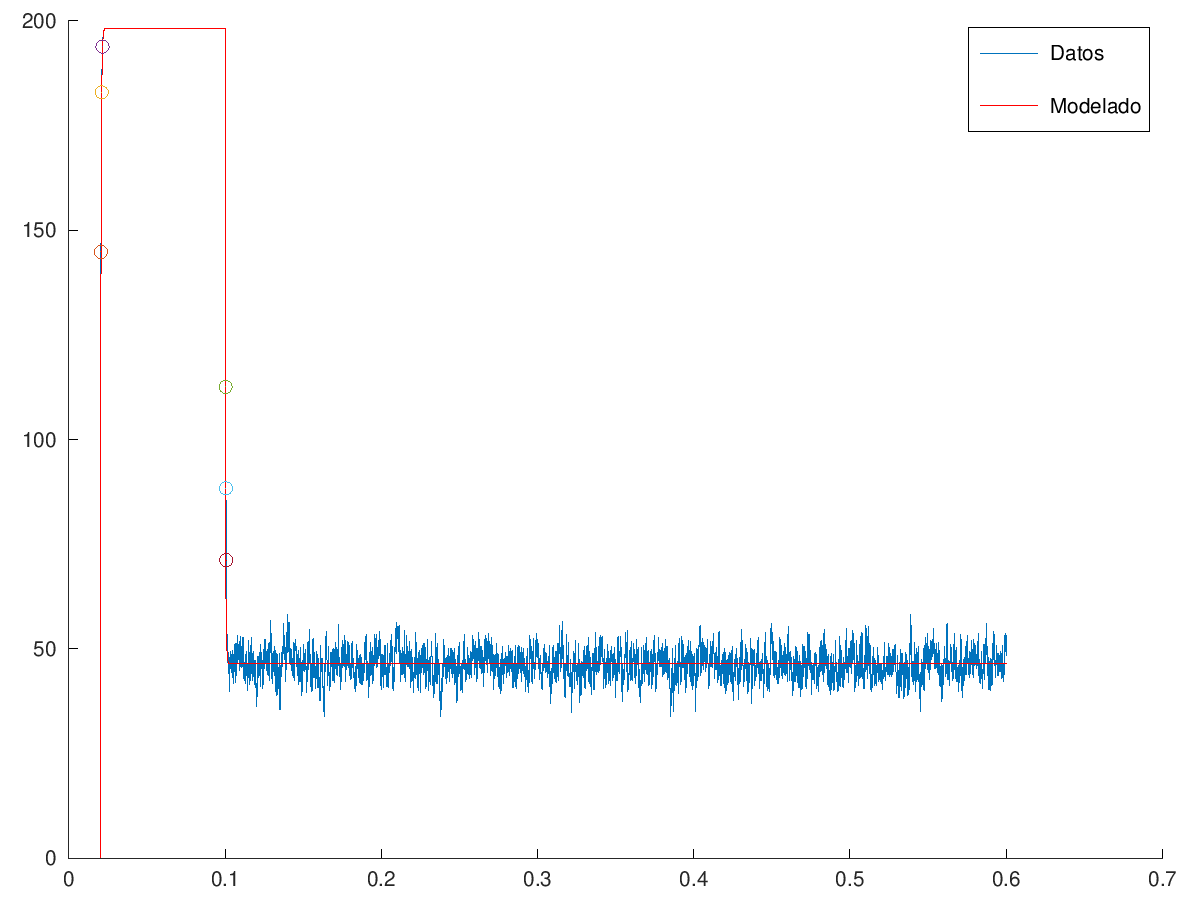

In [ ]:
!octave -W ID_Chen.m
import scipy.io
mat = scipy.io.loadmat('/content/ID_Chen.mat')
from PIL import Image
imt = Image.open("/content/Resultados_ID_Chen.png")
imt

También puede emplearse el comando save() desde el script, y luego desde Colab levantar el archivo. En éste caso ID_Chen.mat.
Luego se emplean funciones Python de matplotlib y se muestran las variables de interés.

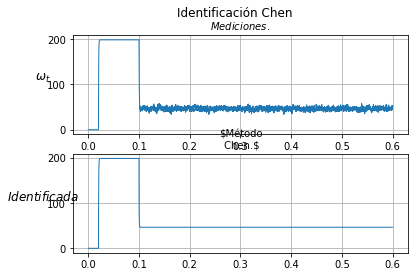

In [ ]:
# -W : no window system
#!octave -W ID_Chen.m
#
import numpy as np
import scipy.io
mat = scipy.io.loadmat('/content/ID_Chen.mat')
#%plot(t,ys,'r');title('Control realimentación de estados');xlabel('Tiempo');
y1=mat.get('y1')
y2=mat.get('y2')
t_s=mat.get('t_s')
t_D=mat.get('t_D')
y_D=mat.get('y_D')
#Importamos los datos que se generaron desde Octave en el archivo .mat
#Ahora empezamos a plotear las variables
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2)
fig.suptitle('Identificación Chen')
axs[0].plot(t_D, y_D, linewidth =1.0)
axs[0].grid( True )
axs[0].set_title('$Mediciones.$', fontsize=10);
axs[0].set_ylabel('$\omega_t$',rotation=0, fontsize=12) 
axs[1].plot(t_s, y1-y2, linewidth =1.0)
axs[1].set_ylabel('$Identificada$',rotation=0, fontsize=12)
axs[1].grid( True )
axs[1].set_title('$Método\n Chen.$', fontsize=10);